# Postprocessing a DeepONet Trained for a 0D Reactor

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import tensorflow                         as tf
from tensorflow                           import keras

import romnet                             as rmnt


In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'

OutputDir     = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_2000Cases_NEq_Shift/'
TestDir       = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_2000Cases_NEq_Shift/'

PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_Isobaric_2000Cases_NEq_Shift/DeepONet/Deterministic/Run_2/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_10Cases/DeepONet/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_10Cases/DeepONet/BayesByBackprop/Run_1/'

DirDir        = OutputDir

# DirName       = 'test'
# CasesVec      = range(5)#[1,0,2]
DirName       = 'train'
CasesVec      = range(10)



NSamples      = 1

NVarsRed      = 13

FixedMinVal   = 1.e-14 

POD_NAME      = 'All'


scale  = 'lin'
MinVal = 1.e-40

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNetFldr)


InputData.InputFilePath = PathToRunFld+'/ROMNet_Input.py'
InputData.TrainIntFlg   = 0
InputData.PathToRunFld  = PathToRunFld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_2000Cases_NEq_Shift/DeepONet/Deterministic/Run_2/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [4]:
SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

Net   = getattr(rmnt.nn, SurrogateType)

model = rmnt.model.Model_Deterministic(InputData)

if (InputData.PhysSystem is not None):
    System = getattr(rmnt.pinn.system, InputData.PhysSystem)
    system = System(InputData)

model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_deterministic.py    ]:   Initializing the ML Model

[ROMNet - model_deterministic.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
[ROMNet - component.py              ]:       Constructing Component: Branch_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x1955dbf70>, <keras.layers.core.dense.Dense object at 0x1956c7760>, <keras.layers.core.dropout.Dropout object at 0x195895940>, <keras.layers.core.dense.Dense object at 0x1958952b0>, <keras.layers.core.dropout.Dropout object at 0x195895070>, <keras.layers.core.dense.Dense object at 0x195895c70>,

[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x195e34730>, <keras.layers.core.dense.Dense object at 0x195e88b20>, <keras.layers.core.dropout.Dropout object at 0x195e8f640>, <keras.layers.core.dense.Dense object at 0x195e9e6a0>, <keras.layers.core.dropout.Dropout object at 0x195e9eb50>, <keras.layers.core.dense.Dense object at 0x195e9ed60>, <keras.layers.core.dropout.Dropout object at 0x195e9ebe0>, <keras.layers.core.dense.Dense object at 0x195ea71f0>])
[ROMNet - component.py              ]:       Constructing Component: Rigid
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x195e88b50>, <keras.layers.core.dense.Dense object at 0x195f14c10>, <keras.layers.core.dropout.Dropout object at 0x195f24310>, <keras.layers.core.de


[ROMNet - model_deterministic.py    ]:   Loading ML Model Parameters from File:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_2000Cases_NEq_Shift/DeepONet/Deterministic/Run_2//Training/Params//001959.h5
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_1_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_1_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_1_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_1_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_1_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_1-Main-HL_1
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_1-Main-HL_1
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_1-Main-

[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_6-Main-HL_3
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_6-Main-HL_3
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_6-Main-HL_4
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_6-Main-HL_4
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Post_softplus_6
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Post_softplus_6
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_7_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_7_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_7_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_7_Normalization
[ROMNet - hdf5_forma

'load_params' took 0.845416 s


[ROMNet - model_deterministic.py    ]:   Saving ML Model Parameters to File:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_2000Cases_NEq_Shift/DeepONet/Deterministic/Run_2//Model/Params/Initial.h5
'save_params' took 0.250197 s

'build' took 13.485820 s



In [5]:
FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/ROM/ToOrig_Mask.csv'
ToOrig_Mask = pd.read_csv(FileName, delimiter=',', header=None).to_numpy(int)[:,0]

In [6]:
### Evaluating on Test Data


FileName = DirDir + '/Orig/train/ext/y.csv.1'
Data     = pd.read_csv(FileName, header=0)
VarNames = list(Data.columns)
VarNames.remove('t')

FileName     = DirDir + '/Orig/train/ext/CleanVars.csv'
Data         = pd.read_csv(FileName, header=0)
VarNamesAnti = list(Data.columns)

        
        
Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

Vars0 = []
for iVars in range(1,NVarsRed+1):
    Vars0.append('PC0_'+str(iVars))
    
SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))
    


FileName     = OutputDir + '/Orig/'+DirName+'/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)

FileName     = OutputDir + '/Orig/'+DirName+'/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
NICs         = len(ICVecs)

In [7]:
InputVars = Vars0+['t']
#InputVars = ['T0']+['t']
InputVars

['PC0_1',
 'PC0_2',
 'PC0_3',
 'PC0_4',
 'PC0_5',
 'PC0_6',
 'PC0_7',
 'PC0_8',
 'PC0_9',
 'PC0_10',
 'PC0_11',
 'PC0_12',
 'PC0_13',
 't']

T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K


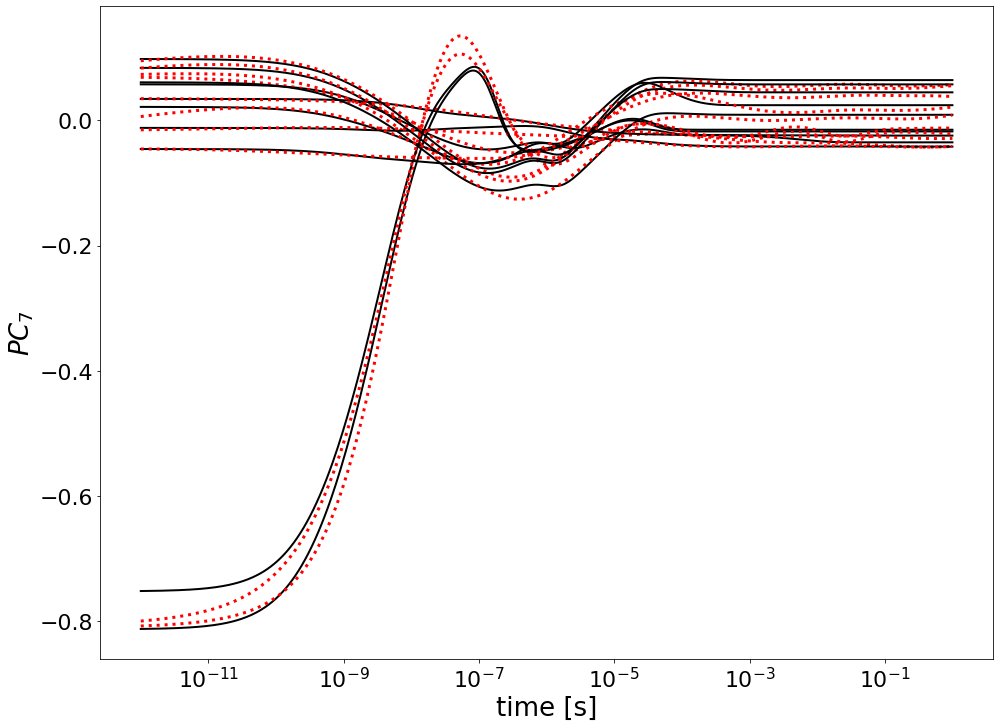

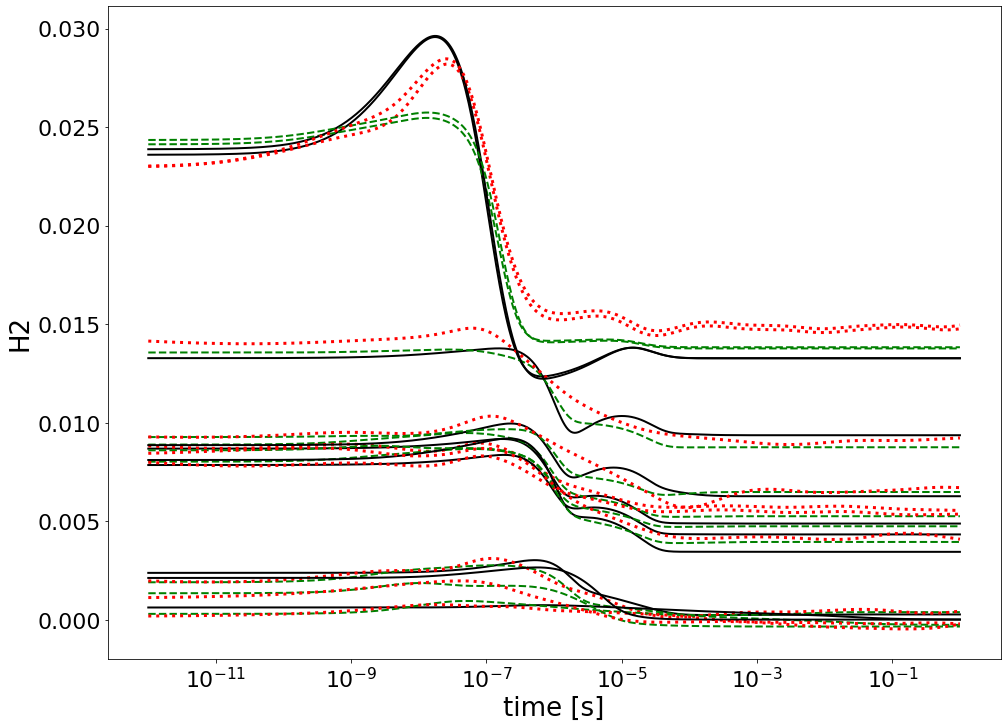

In [8]:
iPC      = 6

VarOI    = 'H2'

if (POD_NAME == 'All'):
    jPC = iPC
else:
    jPC = 0


iVar     = VarNames.index(VarOI)
iVarAnti = VarNamesAnti.index(VarOI)



ax  = []

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())
for iTest in CasesVec:
    Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
    P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
    EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
    T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
    #####################################################################################################
    FileName     = DirDir + '/Orig/'+DirName+'/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    tVec[tVec == 0.] = FixedMinVal
    y_Data       = Data[VarNames].to_numpy()
    print('T = ', Data['T'].to_numpy()[0], 'K')
    

    #####################################################################################################
    if (POD_NAME == 'All'):
        FileName         = OutputDir+'/'+str(NVarsRed)+'PC/'+DirName+'/ext/PC.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)
        tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
        yPCA_Data        = Data[Vars].to_numpy()
        Data0            = Data[Data['t'] == 0.][Vars]
    if (scale == 'lin'):
        yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
        yPre_Data        = yPCA_Data.dot(A)
        yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
    elif (scale == 'log'):
        yPCA_Data        = ((np.log(y_Data[:,ToOrig_Mask] + MinVal) - C[:,0])/D[:,0]).dot(A.T)
        yPre_Data        = yPCA_Data.dot(A)
        yAnti_Data       = np.exp(yPre_Data * D[:,0] + C[:,0]) - 1.e-40
    elif (scale == 'log10'):
        yPCA_Data        = ((np.log(y_Data[:,ToOrig_Mask] + MinVal) - C[:,0])/D[:,0]).dot(A.T)
        yPre_Data        = yPCA_Data.dot(A)
        yAnti_Data       = 10.**(yPre_Data * D[:,0] + C[:,0]) - 1.e-40
    Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)
    
    Data0            = Data0.loc[Data0.index.repeat(Nts)]
    Data0.columns    = Vars0
    Data0['T0']      = T0Vec
    Data0['t']       = tVec
    Data0['log10(t)']= np.log10(tVec)
    Data0['log(t)']  = np.log(tVec)
    Data0.reset_index(drop=True, inplace=True)
        
    
    ax[0].plot(tVec, yPCA_Data[:,iPC], '-k',  label='From ODE', lw=2)
    if (POD_NAME == 'All'):
        ax[1].plot(tVec, y_Data[:,iVar],  '-k',  label='From ODE', lw=2)
        ax[1].plot(tVec, yAnti_Data[:,iVarAnti], '--g',  label='From PCA', lw=2)

    
    if (InputData.ProbApproach == 'Deterministic') and (NSamples == 1):
        
        yPCA_Pred  = model.predict(Data0[InputVars])
        ax[0].plot(tVec, yPCA_Pred[:,jPC], 'r:', label='DeepONet', lw=3)

        if (POD_NAME == 'All'):
            yPre_Pred  = yPCA_Pred.dot(A)
            if (scale == 'lin'):
                yAnti_Pred = (yPre_Pred)*D[:,0] + C[:,0]
            elif (scale == 'log'):
                yAnti_Pred = np.exp( (yPre_Pred)*D[:,0] + C[:,0] ) - MinVal
            elif (scale == 'log10'):
                yAnti_Pred = 10.**( (yPre_Pred)*D[:,0] + C[:,0] ) - MinVal
            ax[1].plot(tVec, yAnti_Pred[:,iVarAnti], 'r:', label='DeepONet', lw=3)
        
    else:
        
        ### Sampling NN
        yPCA_Pred_sum  = np.zeros((yPCA_Data.shape[0], yPCA_Data.shape[1]))
        yPCA_Pred_sqr  = np.zeros((yPCA_Data.shape[0], yPCA_Data.shape[1]))
        if (POD_NAME == 'All'):
            yAnti_Pred_sum = np.zeros((yAnti_Data.shape[0], A.shape[1]))
            yAnti_Pred_sqr = np.zeros((yAnti_Data.shape[0], A.shape[1]))

        for iSample in range(NSamples):
            yPCA_Pred = model.predict(Data0[InputVars])
            
            yPCA_Pred_sum  += yPCA_Pred
            yPCA_Pred_sqr  += yPCA_Pred**2
            
            if (POD_NAME == 'All'):
                yAnti_Pred      = (yPCA_Pred.dot(A))*D[:,0] + C[:,0]
                yAnti_Pred_sum += yAnti_Pred
                yAnti_Pred_sqr += yAnti_Pred**2
            
        yMat_pca_mean = yPCA_Pred_sum/NSamples
        yMat_pca_std  = np.sqrt( yPCA_Pred_sqr/NSamples - yMat_pca_mean**2 )
        yMat_pca_p1   = yMat_pca_mean + 1.*yMat_pca_std
        yMat_pca_m1   = yMat_pca_mean - 1.*yMat_pca_std
        yMat_pca_p2   = yMat_pca_mean + 2.*yMat_pca_std
        yMat_pca_m2   = yMat_pca_mean - 2.*yMat_pca_std
        yMat_pca_p3   = yMat_pca_mean + 3.*yMat_pca_std
        yMat_pca_m3   = yMat_pca_mean - 3.*yMat_pca_std
            
        if (POD_NAME == 'All'):
            yMat_mean = yAnti_Pred_sum/NSamples
            yMat_std  = np.sqrt( yAnti_Pred_sqr/NSamples - yMat_mean**2 )
            yMat_p1   = yMat_mean + 1.*yMat_std
            yMat_m1   = yMat_mean - 1.*yMat_std
            yMat_p2   = yMat_mean + 2.*yMat_std
            yMat_m2   = yMat_mean - 2.*yMat_std
            yMat_p3   = yMat_mean + 3.*yMat_std
            yMat_m3   = yMat_mean - 3.*yMat_std
    
        ax[0].plot(tVec, yMat_pca_mean[:,iPC], 'b-', label=r'DeepONet, $\mu$')
        ax[0].plot(tVec, yMat_pca_p3[:,iPC],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[0].plot(tVec, yMat_pca_m3[:,iPC],   'b:', label=r'DeepONet, $\mu-3\sigma$')

        if (POD_NAME == 'All'):
            ax[1].plot(tVec, yMat_mean[:,iVarAnti],  'b-', label=r'DeepONet, $\mu$')
            ax[1].plot(tVec, yMat_p3[:,iVarAnti],    'b:', label=r'DeepONet, $\mu+3\sigma$')
            ax[1].plot(tVec, yMat_m3[:,iVarAnti],  'b:', label=r'DeepONet, $\mu-3\sigma$')
    
    
ax[0].set_xscale('log')

ax[0].set_xlabel('time [s]')
ax[0].set_ylabel(r'$PC_'+str(iPC+1)+'$')
#ax[0].set_xlim([1.e-8,1.e-2])
#ax[0].legend()

if (POD_NAME == 'All'):
    ax[1].set_xscale('log')
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel(VarOI)
    #ax[1].set_xlim([1.e-8,1.e-2])
    #ax[1].legend()

T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K
T =  300.0 K


Text(0, 0.5, '$PC_6$')

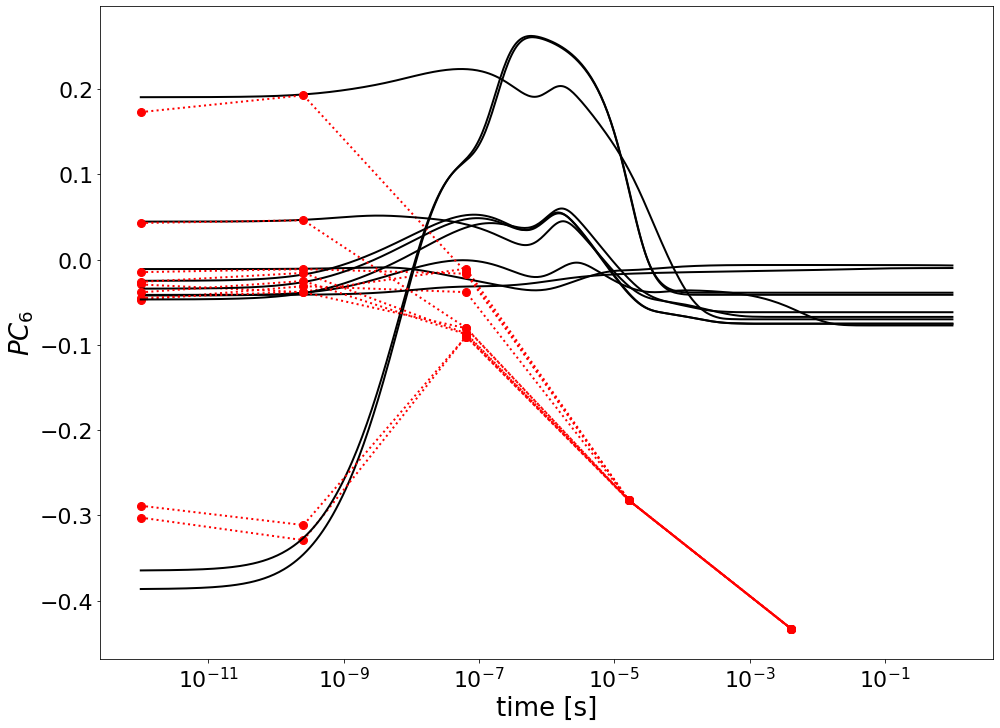

In [24]:
iPC      = 5

VarOI    = 'H2'

if (POD_NAME == 'All'):
    jPC = iPC
else:
    jPC = 0


iVar     = VarNames.index(VarOI)
iVarAnti = VarNamesAnti.index(VarOI)


ax  = []

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())

# fig = plt.figure(figsize=(16,12))
# ax.append(plt.axes())

for iTest in CasesVec:
    Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
    P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
    EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
    T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
    #####################################################################################################
    FileName     = DirDir + '/Orig/'+DirName+'/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    tVec[tVec == 0.] = FixedMinVal
    y_Data       = Data[VarNames].to_numpy()
    print('T = ', Data['T'].to_numpy()[0], 'K')
    

    #####################################################################################################
    if (POD_NAME == 'All'):
        FileName         = OutputDir+'/'+str(NVarsRed)+'PC/'+DirName+'/ext/PC.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)
        tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
        yPCA_Data        = Data[Vars].to_numpy()
        Data0            = Data[Data['t'] == 0.][Vars]
    if (scale == 'lin'):
        yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
    elif (scale == 'log'):
        yPCA_Data        = ((np.log(y_Data[:,ToOrig_Mask] + MinVal) - C[:,0])/D[:,0]).dot(A.T)
    yPre_Data            = yPCA_Data.dot(A)
    yAnti_Data           = yPre_Data * D[:,0] + C[:,0]
    Data0                = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

    ax[0].plot(tVec, yPCA_Data[:,iPC], '-k',  label='From ODE', lw=2)
#     if (POD_NAME == 'All'):
#         ax[1].plot(tVec, y_Data[:,iVar],  '-k',  label='From ODE', lw=2)
#         ax[1].plot(tVec, yAnti_Data[:,iVarAnti], '--g',  label='From PCA', lw=2)
        
#     NLoop                = 50
#     tLoop                = np.logspace(np.log10(tVec[10]), np.log10(tVec[-1]), NLoop)
#     DataLoop             = Data0.loc[Data0.index.repeat(NLoop)]#.drop([0])
#     DataLoop.columns     = Vars0
#     DataLoop['t']        = tLoop
#     DataLoop['log10(t)'] = np.log10(tLoop)
#     DataLoop['log(t)']   = np.log(tLoop)
#     DataLoop.reset_index(drop=True, inplace=True)

#     yMatLoop      = np.zeros((NLoop,7))
#     InputPredLoop = np.concatenate([Data0.loc[0].to_numpy()[np.newaxis,...], (tLoop[0])[np.newaxis,np.newaxis]], axis=1)
#     yMatLoop[0,:] = model.predict(InputPredLoop)
#     for it, tLoop_ in enumerate(tLoop[1:]):
#         InputPredLoop    = np.concatenate([yMatLoop[it,:][np.newaxis,...], (tLoop[it+1]-tLoop[it])[np.newaxis,np.newaxis]], axis=1)
#         yMatLoop[it+1,:] = model.predict(InputPredLoop)

    Idxs                 = range(0,len(tVec),100)
    tLoop                = tVec[Idxs]
    NLoop                = len(tLoop)
    DataLoop             = Data0.loc[Data0.index.repeat(NLoop)]#.drop([0])
    DataLoop.columns     = Vars0
    DataLoop['t']        = tLoop
    DataLoop['log10(t)'] = np.log10(tLoop)
    DataLoop['log(t)']   = np.log(tLoop)
    DataLoop.reset_index(drop=True, inplace=True)

    yMatLoop      = np.zeros((NLoop,NVarsRed))
    InputPredLoop = np.concatenate([Data0.loc[0].to_numpy()[np.newaxis,...], (tLoop[0])[np.newaxis,np.newaxis]], axis=1)
    yMatLoop[0,:] = model.predict(InputPredLoop)
    for it, tLoop_ in enumerate(tLoop[1:]):
        InputPredLoop    = np.concatenate([yPCA_Data[Idxs[it],:][np.newaxis,...], (tLoop[it+1]-tLoop[it])[np.newaxis,np.newaxis]], axis=1)
        yMatLoop[it+1,:] = model.predict(InputPredLoop)
        
    
    ax[0].plot(tLoop, yMatLoop[:,iPC], ':or')

    
ax[0].set_xscale('log')

ax[0].set_xlabel('time [s]')
ax[0].set_ylabel(r'$PC_'+str(iPC+1)+'$')
#ax[0].set_xlim([1.e-8,1.e-2])
#ax[0].legend()

# if (POD_NAME == 'All'):
#     ax[1].set_xscale('log')
#     ax[1].set_xlabel('time [s]')
#     ax[1].set_ylabel(VarOI)
#     #ax[1].set_xlim([1.e-8,1.e-2])
#     #ax[1].legend()

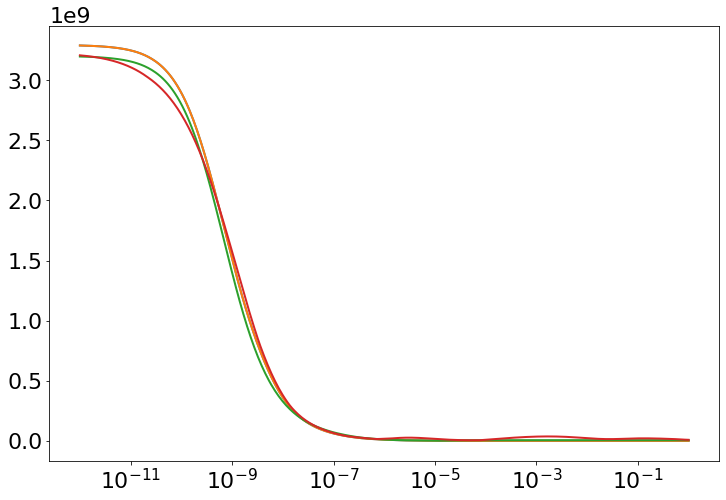

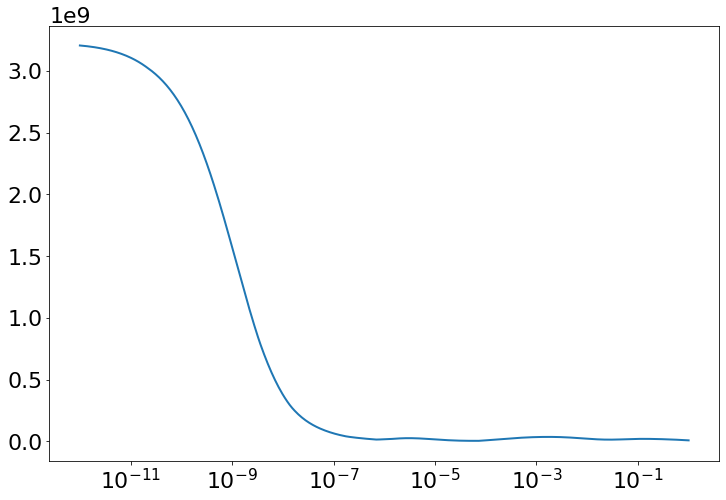

In [10]:
if (POD_NAME == 'All'):
    
    VarOI    = 'T'

    iVar     = VarNames.index(VarOI)
    iVarAnti = VarNamesAnti.index(VarOI)


    FileName      = DirDir + '/Orig/'+DirName+'/ext/ySource.csv.' + str(iTest+1)
    DataSource    = pd.read_csv(FileName, header=0)
    dydtAnti_Data = DataSource[VarNamesAnti].to_numpy()
    dydtPre_Data  = dydtAnti_Data/D.T


    ZeroDR  = rmnt.pinn.system.ZeroDR(InputData)

    yPre_RealData      = (y_Data[:,ZeroDR.to_orig] - ZeroDR.C) / ZeroDR.D
    dydtPre_RealData_f = ZeroDR.f(0., yPre_RealData, None)
    dydtPre_RealData_n = np.gradient(yPre_RealData[:,iVarAnti], tVec) #* tVec[:,0]

    dydtPre_Data_f     = ZeroDR.f(0., yPre_Data, None)
    dydtPre_Data_n     = np.gradient(yPre_Data[:,iVarAnti], tVec) #* tVec[:,0]

    dydtPre_Pred_f     = ZeroDR.f(0., yPre_Pred,  None)
    dydtPre_Pred_n     = np.gradient(yPre_Pred[:,iVarAnti], tVec) #* tVec[:,0]

    fig = plt.figure(figsize=(12,8))
    plt.plot(tVec, dydtPre_Data[:,iVarAnti])
    plt.plot(tVec, dydtPre_RealData_f[:,iVarAnti])
    plt.plot(tVec, dydtPre_Data_f[:,iVarAnti])
    plt.plot(tVec, dydtPre_Pred_f[:,iVarAnti])
    plt.xscale('log')
    # plt.xlim([1.e-14,1.e-13])
    # plt.ylim([-1e9, 1e7])


    fig = plt.figure(figsize=(12,8))

    #plt.plot(tVec, dydtPre_RealData_f[:,iVarAnti])
    #plt.plot(tVec, dydtPre_RealData_n)

    # plt.plot(tVec, dydtPre_Data_f[:,iVarAnti])
    #plt.plot(tVec, dydtPre_Data_n)

    plt.plot(tVec, dydtPre_Pred_f[:,iVarAnti])
    #plt.plot(tVec, dydtPre_Pred_n)

    plt.xscale('log')
    # plt.xlim([1.e-14,1.e-13])
    # plt.ylim([-1e9, 1e7])

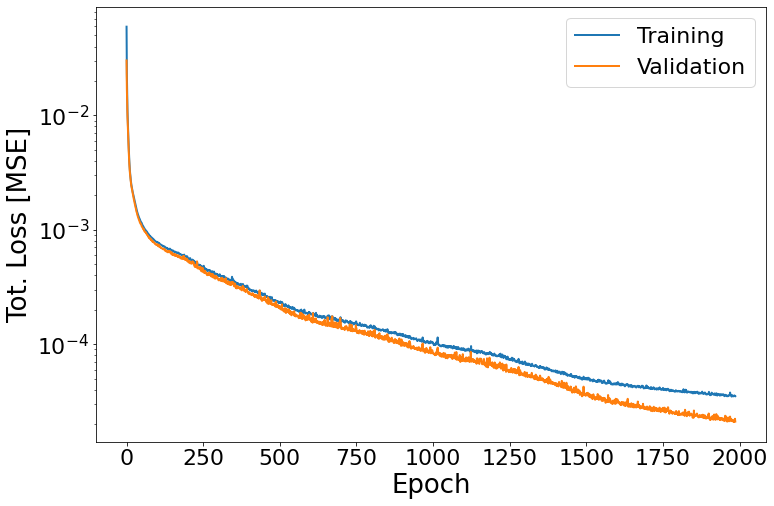

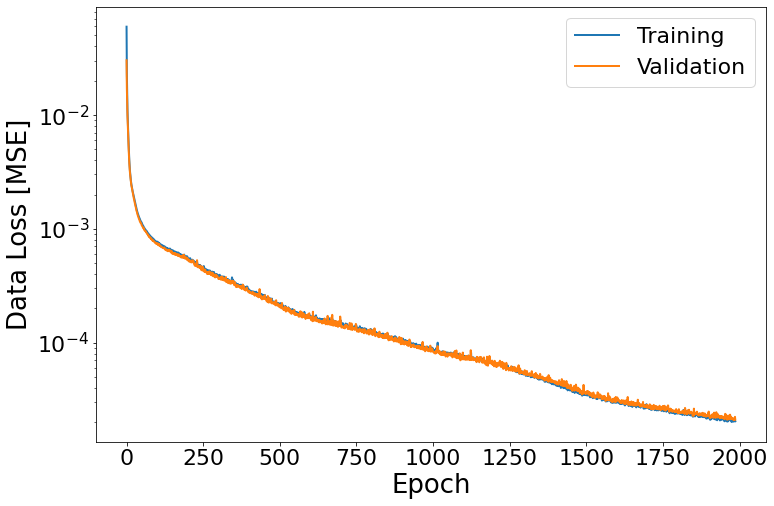

In [11]:
Data = pd.read_csv(PathToRunFld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

In [12]:
# iPC = 6

# FileName       = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
# Data           = pd.read_csv(FileName, header=0)
# tVec           = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
# yPCA_Data      = Data[Vars].to_numpy()

# FileName       = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PCSource.csv.'+str(iTest+1)
# DataSource     = pd.read_csv(FileName, header=0)
# dPCdt_Data     = DataSource[SVars].to_numpy()

# dPCdt_Data_f   = ZeroDR.f_pc(0., yPCA_Data,  None)
# dPCdt_Data_n   = np.gradient(yPCA_Data[:,iPC], tVec) #* tVec[:,0]

# dPCdt_Pred_f   = ZeroDR.f_pc(0., yPCA_Pred,  None)
# dPCdt_Pred_n   = np.gradient(yPCA_Pred[:,iPC], tVec) #* tVec[:,0]



# fig = plt.figure(figsize=(12,8))

# #plt.plot(tVec, dPCdt_Data[:,iPC])

# #plt.plot(tVec, dPCdt_Data_f[:,iPC])
# #plt.plot(tVec, dPCdt_Data_n)

# plt.plot(tVec, dPCdt_Pred_f[:,iPC]/model.output_range[iPC])
# plt.plot(tVec, dPCdt_Pred_n/model.output_range[iPC])

# plt.xscale('log')
# # plt.xlim([1.e-14,1.e-13])
# # plt.ylim([-1e9, 1e7])

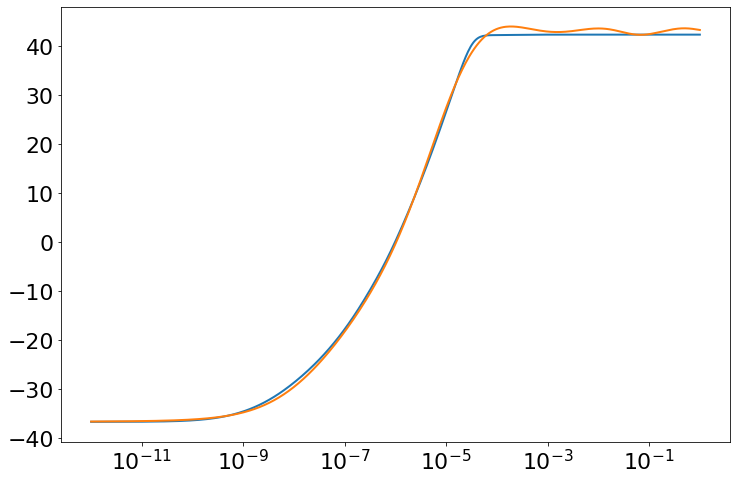

In [13]:
fig = plt.figure(figsize=(12,8))
plt.plot(tVec, yPCA_Data[:,iPC])
plt.plot(tVec, yPCA_Pred[:,iPC])
plt.xscale('log')
# plt.xlim([1.e-14,1.e-13])
# plt.ylim([-1e9, 1e7])

In [14]:
# iPC = 0

# fig = plt.figure(figsize=(12,8))

# DataIn = pd.read_csv('/Users/sventur/Desktop/DAJE/Input.csv', header=None).to_numpy()
# plt.plot(DataIn[:,0], DataIn[:,iPC+1], 'o')

# plt.plot(tVec, yPCA_Pred[:,iPC])

# plt.xscale('log')

In [15]:
# Data = pd.read_csv('/Users/sventur/Desktop/DAJE/Output.csv', header=None).to_numpy()

# dPCdt_Pred_f   = ZeroDR.f_pc(0., DataIn[:,1:],  None)
# #dPCdt_Pred_n   = np.gradient(DataIn[-1000:-1,iPC+1], DataIn[-1000:-1,0]) #* tVec[:,0]



# fig = plt.figure(figsize=(12,8))

# plt.plot(Data[-1000:-1,0], Data[-1000:-1,iPC+1],   'b+', markersize=4)
# #plt.plot(DataIn[-1000:-1,0], dPCdt_Pred_n/model.y_range[iPC], 'ro', markersize=1)

# plt.xscale('log')
# # plt.xlim([-5, -4])
# # plt.ylim([-1, -0.9])



# fig = plt.figure(figsize=(12,8))

# plt.plot(Data[-1000:-1,0], Data[-1000:-1,iPC+6], 'g+', markersize=8)
# plt.plot(DataIn[-1000:-1,0], dPCdt_Pred_f[-1000:-1,iPC]/model.y_range[iPC], 'ro', markersize=1)

# plt.xscale('log')
# # plt.xlim([-5, -4])
# # plt.ylim([-1, -0.9])

In [16]:
# Data    = pd.read_csv(OutputDir+'/Orig/train/ext/ICs.csv')

# ICs      = np.zeros((5,2))
# ICs[:,0] = [2.5, 1.9, 3.5, 1., 3.6]
# ICs[:,1] = [1200., 1900., 1300., 1600., 1700.]

# plt.figure(figsize=(10,10))
# plt.plot(Data.EqRatio, Data['T'], 'o')
# plt.plot(ICs[:,0],ICs[:,1],'ro')
# plt.xlabel('Eq Ratio')
# plt.ylabel('T [K]')

Text(0, 0.5, '$\\Psi_{2_{10}}$')

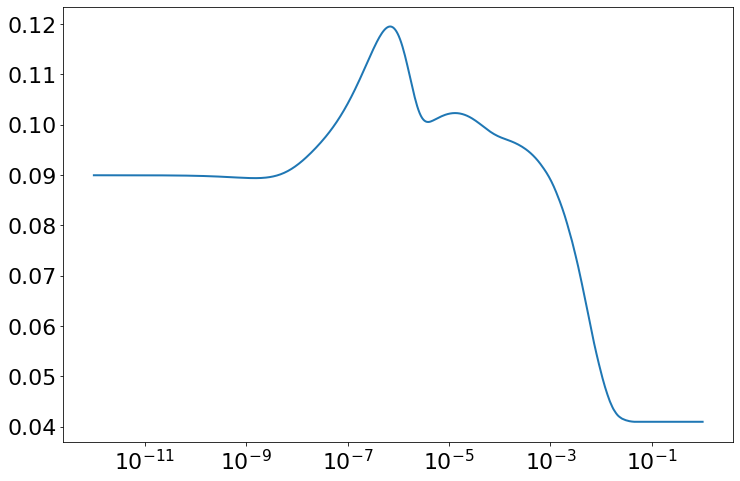

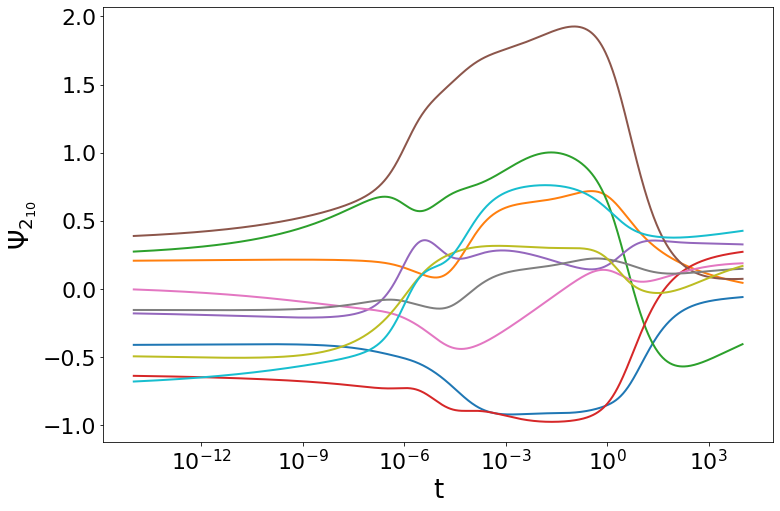

In [17]:
iTrunk           = 1
iTest            = 0

FileName         = OutputDir+'/'+str(NVarsRed)+'PC/'+DirName+'/ext/PC.csv.'+str(iTest+1)
Data             = pd.read_csv(FileName, header=0)

fig = plt.figure(figsize=(12,8))
plt.plot(Data['t'], Data['PC_'+str(iTrunk+1)])
plt.xscale('log')


iVarVec = range(10)

tVecTot = np.logspace(-14,4,1000)

output_ = model.net.system_of_components['DeepONet'].components['Trunk_'+str(iTrunk+1)].call(tVecTot[...,np.newaxis], model.net.layers_dict, None, None, training=False)



fig = plt.figure(figsize=(12,8))

for iVar in iVarVec:

    plt.plot(tVecTot, output_[:,iVar])

#plt.xlim([1.e-6, 1.e-2])
plt.xscale('log')
plt.xlabel('t')
plt.ylabel(r'$\Psi_{'+str(iTrunk+1)+'_{'+str(iVar+1)+'}}$')

In [18]:
FileName     = OutputDir + '/Orig/train/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)


FileName     = OutputDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
NICs         = len(ICVecs)

Cols   = []
NewFlg = True
for iC in range(NICs):

    Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
    NtsNow               = Nts



    FileName             = OutputDir+'/'+str(NVarsRed)+'PC/'+DirName+'/ext/PC.csv.'+str(iC+1)
    Data                 = pd.read_csv(FileName, header=0)

    DataICTemp  = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]].iloc[0]

    if (NewFlg):
        DataIC           = DataICTemp
        NewFlg           = False
    else:
        DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
        Cols.append(str(iC+1))

tVec              = Data['t']
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

Text(0.5, 0, '$\\alpha_{2_D}$')

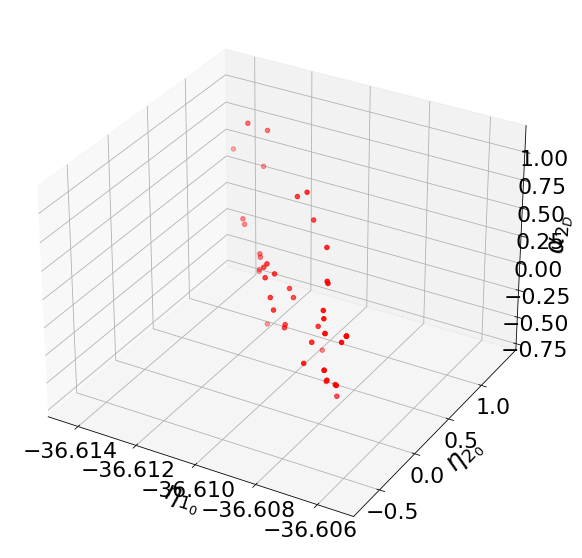

In [19]:
iBranch = 1
iVar    = 0



output_ = model.net.system_of_components['DeepONet'].components['Branch_'+str(iBranch+1)].call(DataIC.to_numpy(), model.net.layers_dict, None, None, training=False)



#%matplotlib qt

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')
ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iVar], c='r')
ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
#ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_{'+str(iVar+1)+'}}$')
ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_D}$')

In [20]:
DataIC

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,-36.609082,0.089973,-0.055780,-0.336850,0.012029,-0.042108,0.057759,-0.058499,-0.013065,-0.089818,0.011087,-0.014506,0.033205
1,-36.609190,-0.120072,-0.459433,-0.073226,-0.010359,-0.041400,0.034475,-0.075124,-0.016919,-0.039986,0.025175,-0.033506,0.047733
2,-36.612160,0.868051,0.538028,0.386948,0.017077,-0.386391,-0.813035,-0.140767,0.415987,-0.050453,0.119074,0.041747,0.014226
3,-36.606775,-0.285721,0.602932,-0.350342,-0.117078,-0.046757,0.061002,-0.027329,-0.015610,0.000625,0.027546,-0.034295,0.005762
4,-36.609661,-0.030270,-0.476366,-0.131712,-0.070049,-0.011095,-0.011848,-0.048854,-0.015827,-0.025301,0.018333,-0.037225,0.047695
5,-36.612167,0.864825,0.531321,0.401542,-0.003312,-0.364583,-0.752416,-0.111252,0.382004,-0.047432,0.109569,0.037389,0.005362
6,-36.607803,0.023535,0.406517,-0.378460,0.159292,-0.034080,0.098306,0.008408,0.030596,-0.020654,0.026383,-0.023619,0.007365
7,-36.608787,0.149651,0.524477,0.022590,-0.079504,0.190491,0.021726,-0.160164,-0.013941,-0.031003,-0.013448,-0.028715,0.006492
8,-36.607941,0.043193,0.390761,-0.391182,0.135831,-0.024884,0.084117,0.006275,0.024050,-0.035810,0.019460,-0.022072,0.009214
9,-36.609091,-0.018628,-0.114850,-0.203896,-0.016969,0.044548,-0.045654,0.044135,0.021350,0.076090,-0.013990,0.018408,0.014092


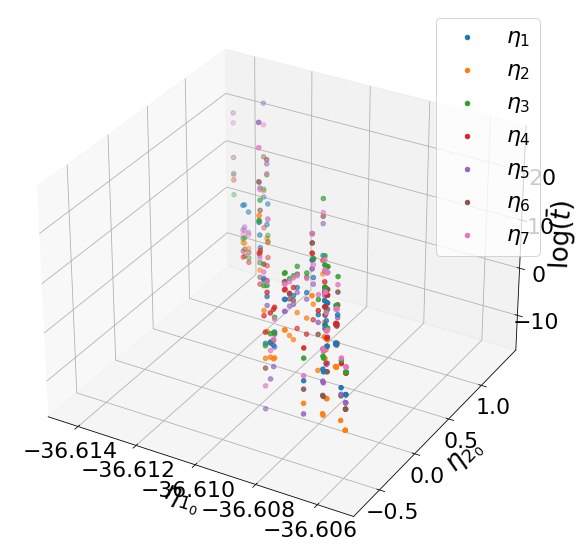

In [21]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')


output_ = model.net.system_of_components['DeepONet'].components['Rigid'].call(DataIC.to_numpy(), model.net.layers_dict, None, None, training=False)

output_.shape

for iBranch in range(7):
    #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
    ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iBranch], label=r'$\eta_{'+str(iBranch+1)+'}$')


ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
ax.set_zlabel(r'$\log(\bar{t})$')
ax.legend()
#ax.set_zscale('log')

In [22]:
# fig = plt.figure(figsize=(10,10))
# ax  = fig.add_subplot(projection='3d')


# output_ = model.net.system_of_components['DeepONet'].components['Rigid'].call(DataIC.to_numpy(), training=False)

# output_.shape

# for iBranch in range(7,14):
#     #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
#     ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iBranch], label=r'$\eta_{'+str(iBranch+1)+'}$')


# ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
# ax.set_zlabel(r'$\log(\bar{t})$')
# ax.legend()
# #ax.set_zscale('log')

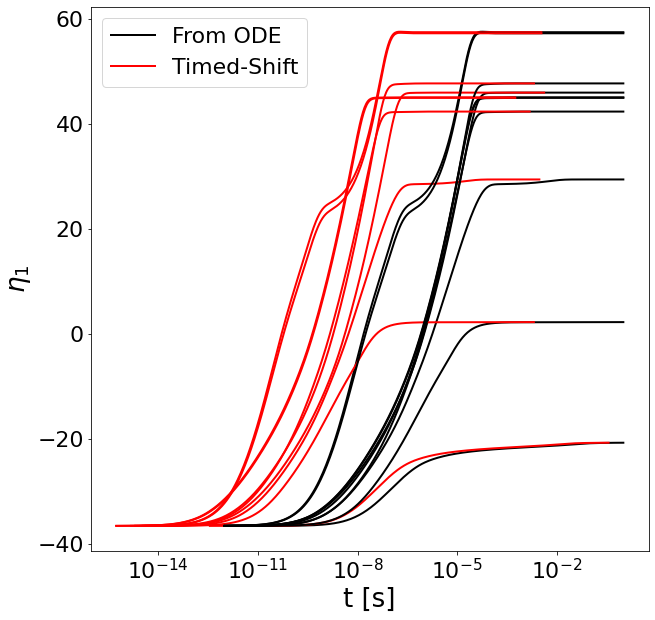

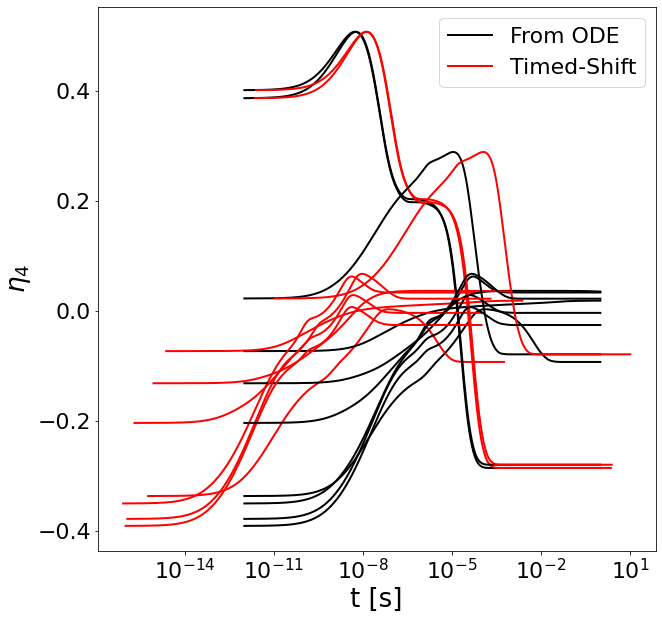

In [23]:
iPCVec   = [0,3]

iTestVec = np.arange(10)

for iPC in iPCVec:

    NewFlg = True
    fig    = plt.figure(figsize=(10,10))
    for iTest in iTestVec:
        
        FileName         = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)
        tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
        yPCA_Data        = Data[Vars].to_numpy()
        Data0            = Data[Data['t'] == 0.][Vars]
#         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
#         yPre_Data        = yPCA_Data.dot(A)
#         yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
#         Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

        if NewFlg:
            Label1 = 'From ODE'
            Label2 = 'Timed-Shift'
            NewFlg = False
        else:
            Label1 = None
            Label2 = None

        plt.plot(tVec, yPCA_Data[:,iPC], '-k',  label=Label1, lw=2)
        plt.plot(np.exp(np.log(tVec+1.e-20)-output_[iTest,iPC]), yPCA_Data[:,iPC], '-r',  label=Label2, lw=2)
    
    axes1 = plt.gca()
    ylim  = axes1.get_ylim()
    #for iTest in iTestVec:

        #plt.vlines(np.exp(output_[iTest,iPC]), ylim[0], ylim[1], colors='r', linestyles='solid')

    plt.xscale('log')
    plt.legend()
    plt.xlabel('t [s]')
    plt.ylabel(r'$\eta_{'+str(iPC+1)+'}$')
    #plt.xlim([1.e-8, 1.e-1])